# Goal

We are interested in understanding when the batched gibbs sampler is unable to converge and what happens in those instances. 
This inability to converge is tightly linked to the warmth of the initialization of the community assignments. We will later on investigate how modularity of the network observations plays a role in the matter. For now, we focus instead in understanding what happens when the batched Gibbs sampler is unable to converge.

Our current theory is that, in this case, the algorithm doesn't learn anything from the network, and thus it tends to build a symmetric clustering (maximum entropy). However, we may suppose that this happens only because we use an uninformative (symmetric) prior on the community probability assignmnents. It could be reasonable that the chain converges instead to the prior distribution in this case. 

Let us focus on the case of the deterministic prior probabilities as in Zhou&Zhang. 
We move around the probability mass of the prior vector and plot statistics on the sampling at an "advanced" state, where we can suppose a "convergence to the prior" might have occurred.

In [7]:
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt
from utils import *
from samplers import *
from Neal_samplers import *

np.random.seed(0)

In [8]:
p = 0.17
q = 0.08
n = 400
k = 4
n_k = n/k
T = 500
burn_in = 0

#might be useful if we want to refer to the loss too
I = -2 * np.log((p*q)**0.5 +((1-p)* (1-q))**0.5 )
theoretical_threshold = np.exp(-n*I / k) # for later use

### True assignment (balanced)

In [9]:
# here we pass a z = [1,1,...,2,2,...,3,3,...,4,4,...4]
z_ex = np.repeat(np.arange(k), n_k)
A, z_true = generate_homogeneous_sbm(n, k, p, q, z_t=z_ex)

### Parameters of beta priors on connectivity probabilities

In [10]:
# for all algorithms
alpha_p_pri = 1
beta_p_pri = 1  

alpha_q_pri = 1
beta_q_pri = 1

### Import "deterministic prior" sampler

In [11]:
from samplers import batched_Gibbs_sampler

### First we identify the "temperature" for the failure of convergence

For now we use a balanced deterministic prior:

In [6]:
pi_pri = np.ones((n,k)) / k 

In [7]:
n_values = 11 # number of values of the mesh of alpha_values
r = 20 # number of iterations for each value of alpha in the mesh
steps = 100 #iterations of the batched sampler
upper_alpha = 0.4

alpha_values = np.linspace(0, 0.5, n_values, dtype=float)
alpha_values 

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ])

In [ ]:
p_list = np.zeros((len(alpha_values), r, steps))
q_list = np.zeros((len(alpha_values), r, steps))
loss_list_batched =  np.zeros((len(alpha_values), r, steps))

for a in range(len(alpha_values)):
    alpha = alpha_values[a]

    print("\nCurrent alpha: ", alpha)
    # initialize the sampler
    z_0 = warm_initializer(z_true, alpha, n ,k)

    # start the different runs
    for run in range(r):
        print("Current (alpha, iteration): ", (alpha, run))
        # run the batched sampler
        
        batched = batched_Gibbs_sampler(A, z_0,
                                            alpha_p_pri, beta_p_pri, 
                                            alpha_q_pri, beta_q_pri, 
                                            pi_pri
                                            )
        batched.run(steps, burn_in = 0)
        z_list_batched = batched.get_z_list()
        losses_batched = [loss(z_true, z_list_batched[i])[0] for i in range(steps)]
        loss_list_batched[a, run, :] = losses_batched
        p_list[a, run, :] = batched.get_p_list()
        q_list[a, run, :] = batched.get_q_list()
    


Alpha:  0.0


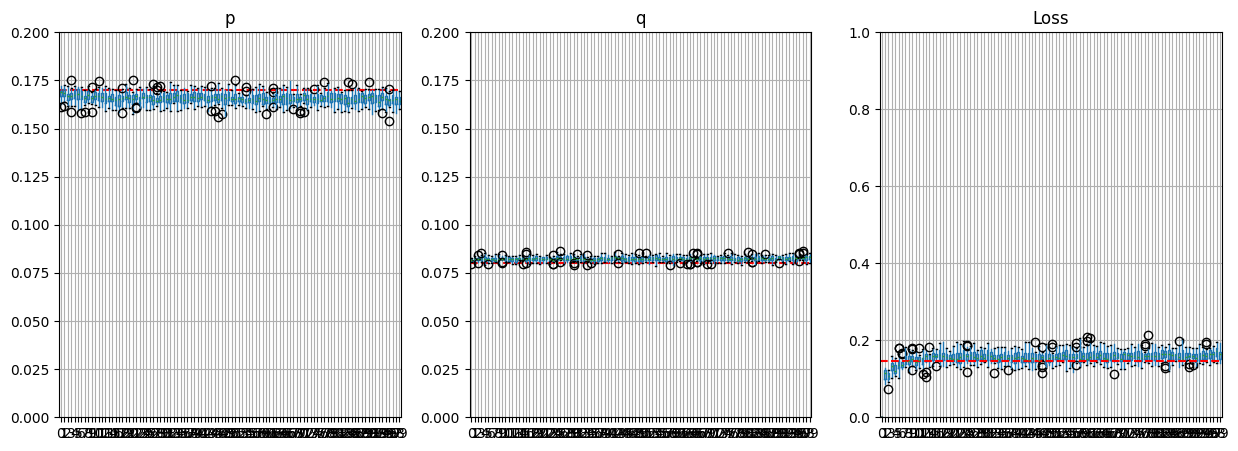

Alpha:  0.05


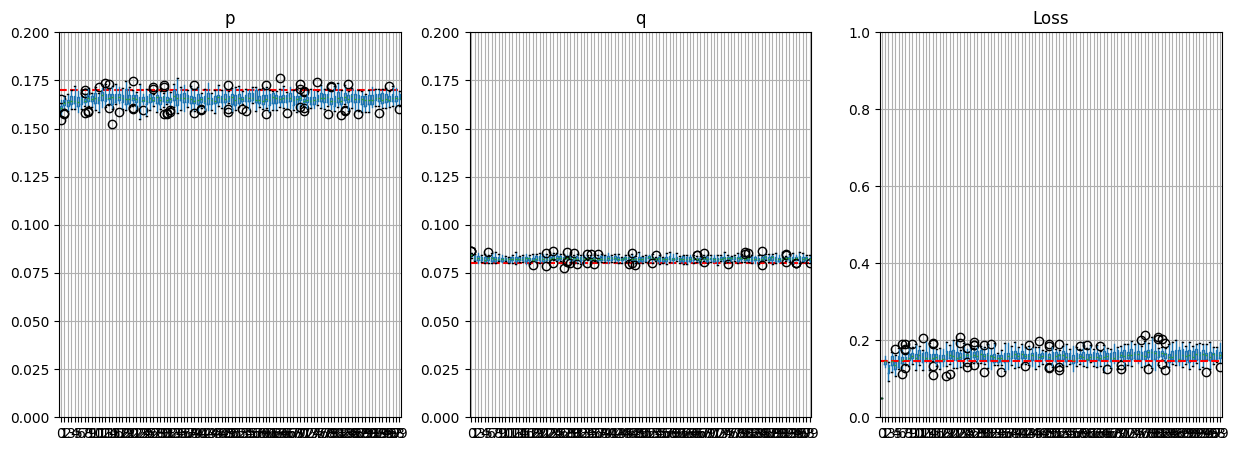

Alpha:  0.1


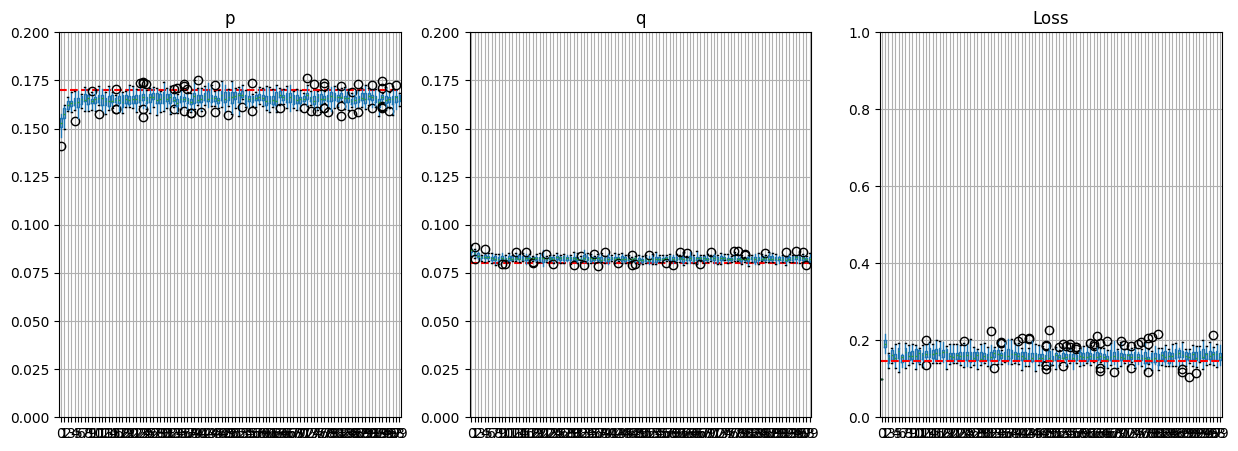

Alpha:  0.15000000000000002


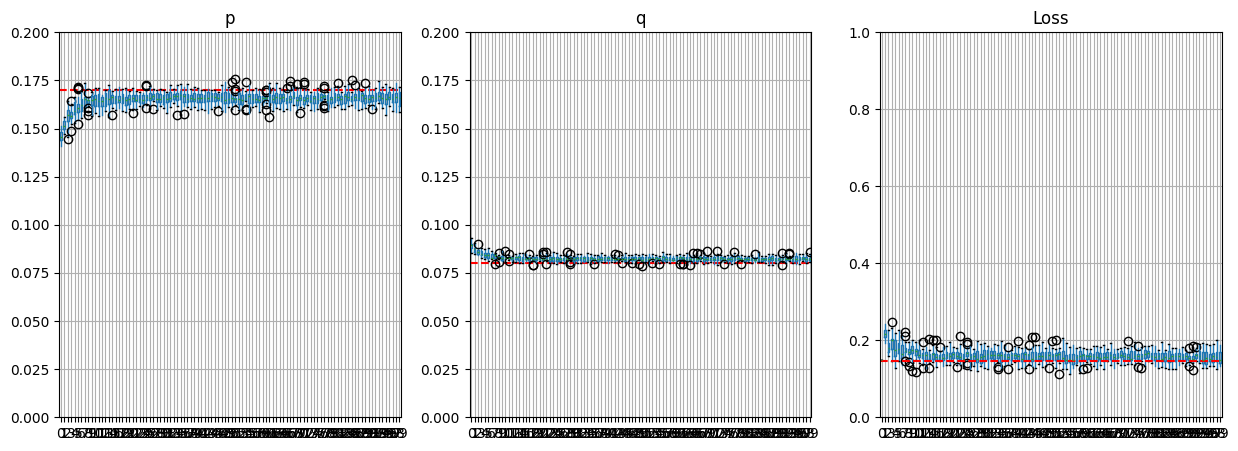

Alpha:  0.2


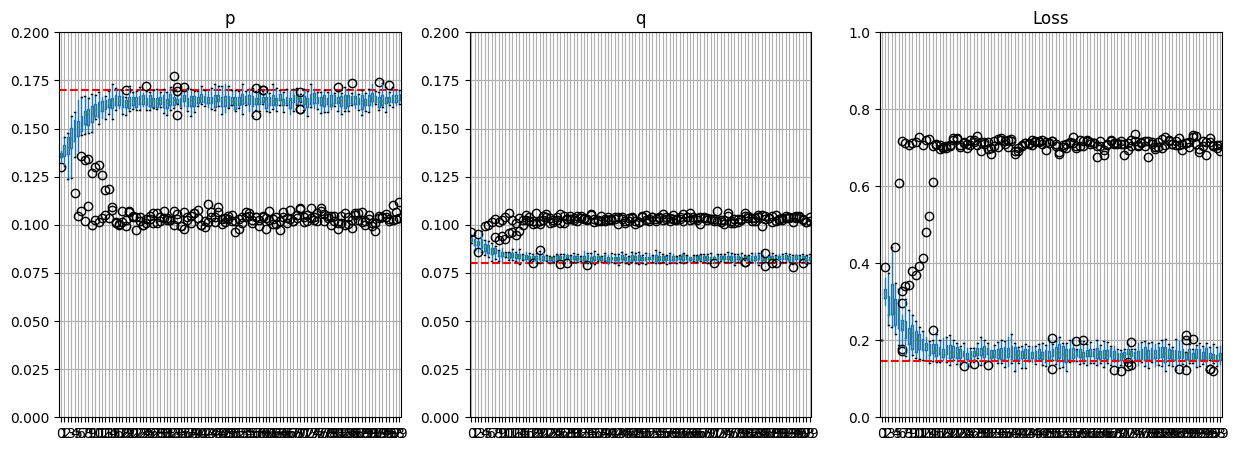

Alpha:  0.25


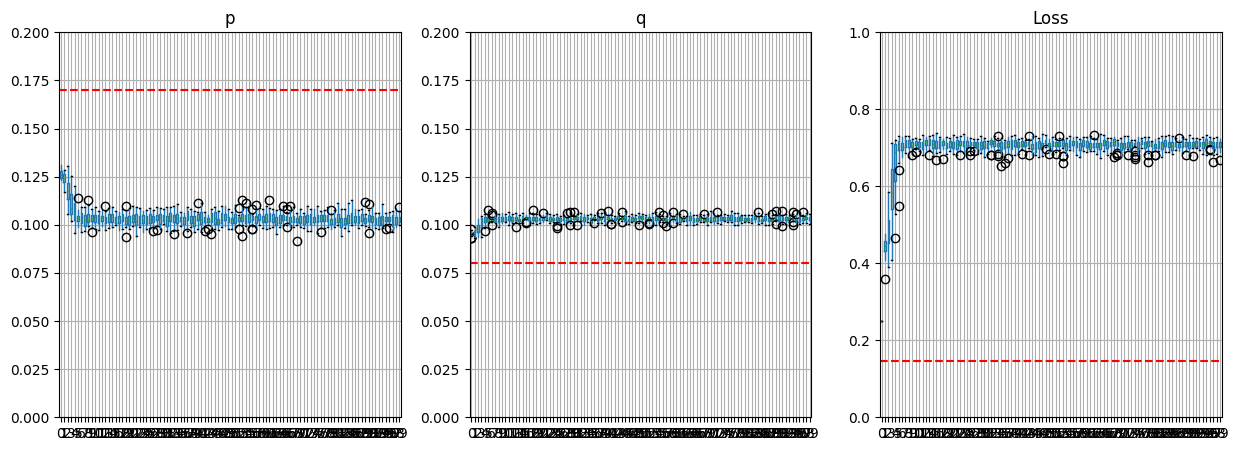

Alpha:  0.30000000000000004


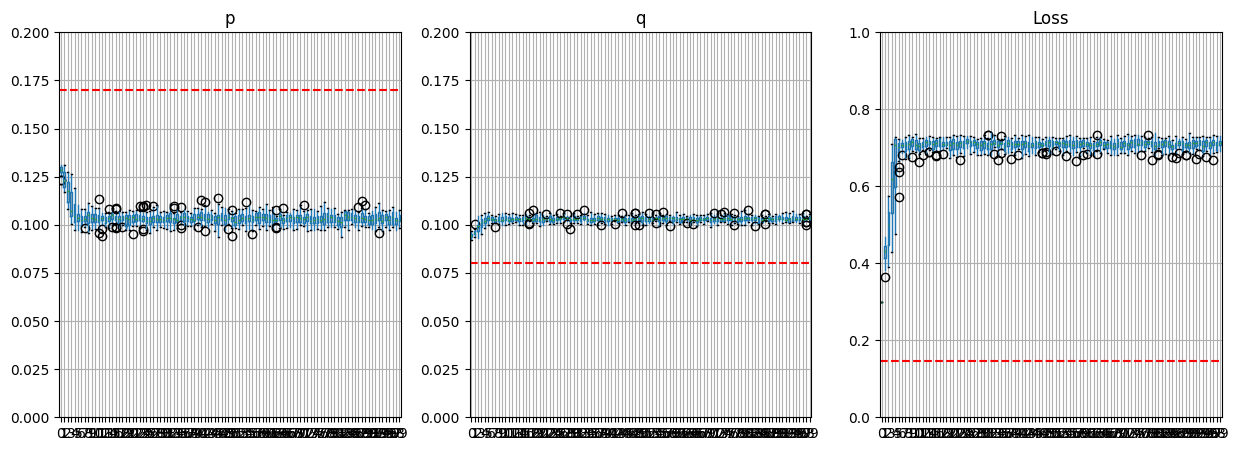

Alpha:  0.35000000000000003


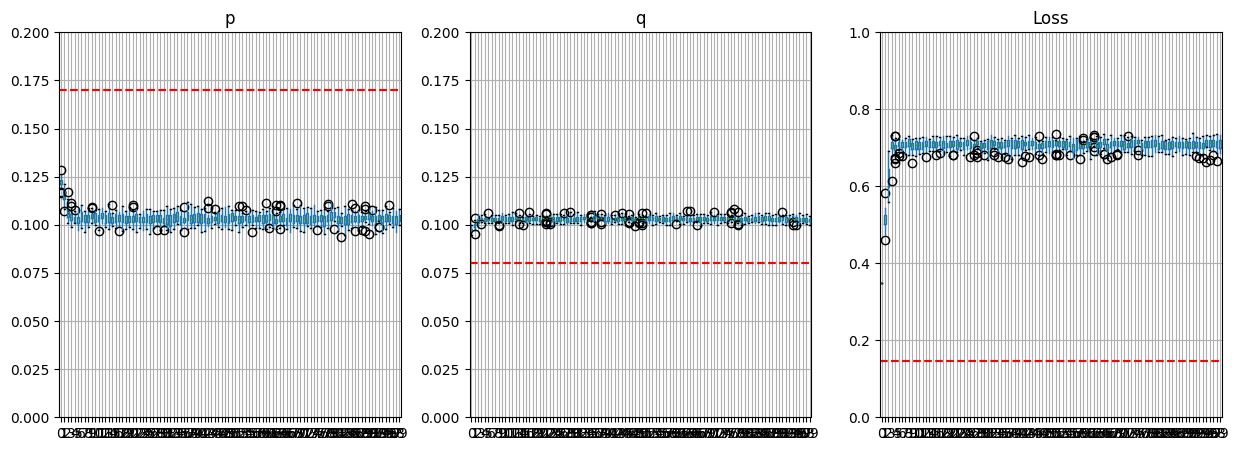

Alpha:  0.4


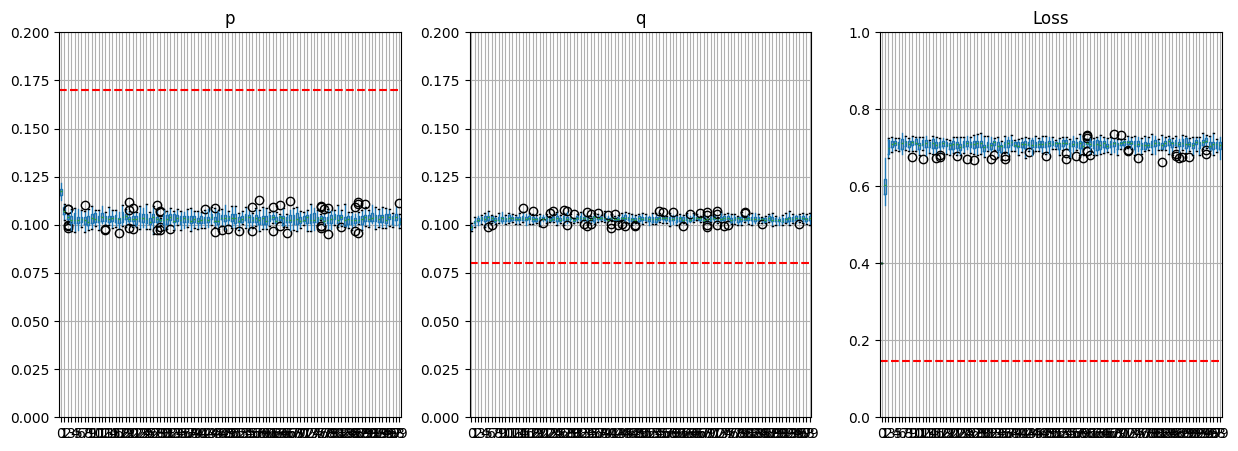

Alpha:  0.45


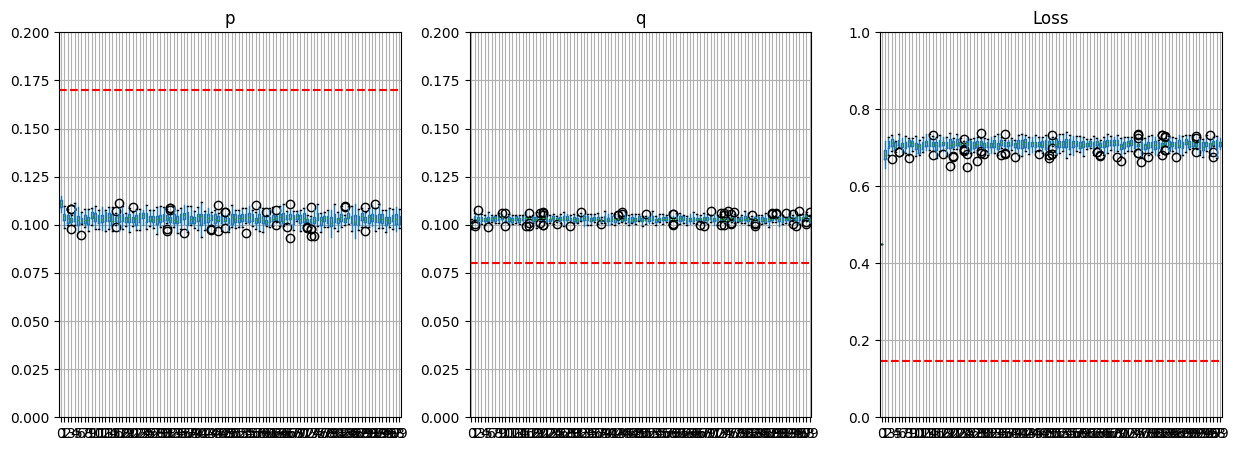

Alpha:  0.5


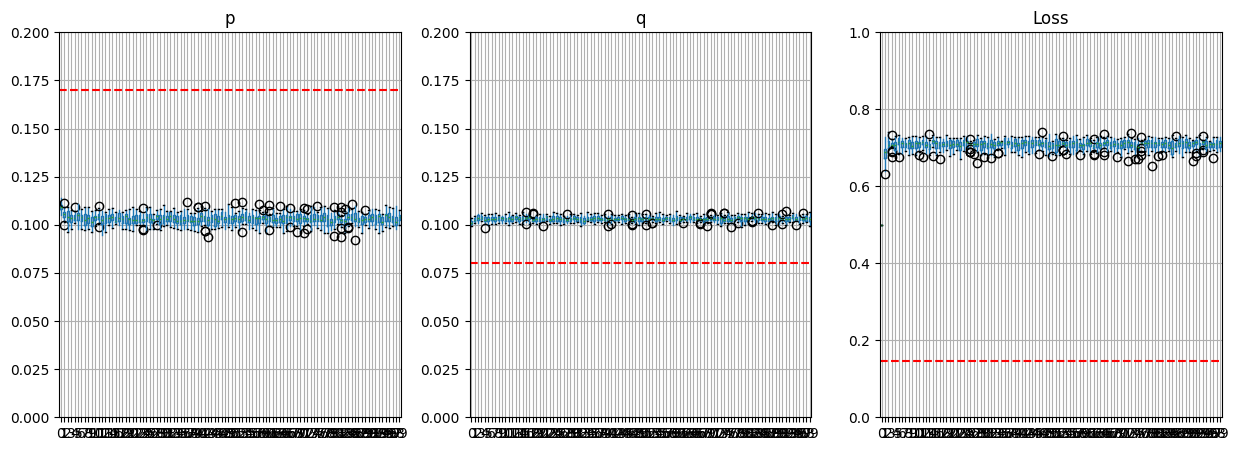

In [9]:
y_lim = 0.20
pic = False
for a in range(len(alpha_values)):
    df_p = pd.DataFrame(p_list[a])
    df_q = pd.DataFrame(q_list[a])
    df_loss = pd.DataFrame(loss_list_batched[a])
    alpha = alpha_values[a]
    print("Alpha: ", alpha)
    plt.figure(figsize=(15, 5))
    plt.subplot(1,3,1)
    plt.title("p")
    plt.axhline(y=p, color='r', linestyle='--')
    df_p.boxplot()
    plt.ylim(0, y_lim)
    plt.subplot(1,3,2)
    plt.title("q")
    plt.axhline(y=q, color='r', linestyle='--')
    df_q.boxplot()
    plt.ylim(0, y_lim)
    plt.subplot(1,3,3)
    plt.title("Loss")
    df_loss.boxplot()
    plt.ylim(0, 1)
    plt.axhline(y=theoretical_threshold, color='r', linestyle='--')

        
    if pic: plt.savefig(f'det_alpha_{alpha}_r_{r}_steps_{steps}.png')

    plt.show()

Conclusions: it appears that the failure of convergence happens at alpha = 1/k on average, for $k=4$.
Running the same simulations for $k=5$? We get a failure of convergence from the very beginning, but the algorithm shows the "stopped learning phenomenon (loss at 0.7 and p=q=0.1) clearly at $1/k$.
**Could further investigate on this**

Going back to $k=4$, we can pick $alpha = 0.3$ to ensure that most instances fail to convergence.
We should now analyze the community balance/imbalance at the "wrong convergence" for varying probability masses on pi_pri.
We mainly assume more weight:
 - on the first class
 - equally on the first two classes
 - equally on the first three
 - equally on all four
 - gradually decreasing from first to fourth
 
To have a grasp of the alleged convergence to the prior weights

In [10]:
# define the priors
pi_pri_list = []

pi_pri1 = np.ones((n,k)) / k
pi_pri_list.append(pi_pri1)

row = [0.70, 0.10, 0.10, 0.10]
pi_pri2 = np.zeros((n,k))
for i in range(n):
    pi_pri2[i, :] = row
pi_pri_list.append(pi_pri2)

row = [0.40, 0.40, 0.10, 0.10]
pi_pri3 = np.zeros((n,k))
for i in range(n):
    pi_pri3[i, :] = row
pi_pri_list.append(pi_pri3)

row = [0.30, 0.30, 0.30, 0.10]
pi_pri4 = np.zeros((n,k))
for i in range(n):
    pi_pri4[i, :] = row
pi_pri_list.append(pi_pri4)

row = [0.4, 0.3, 0.2, 0.1]
pi_pri5 = np.zeros((n,k))
for i in range(n):
    pi_pri5[i, :] = row
pi_pri_list.append(pi_pri5)


In [11]:
# run the samplers r times for each prior, for steps iterations

r = 10 # number of iterations for each value of alpha in the mesh
steps = 200 #iterations of the batched sampler
alpha = 0.4
burn_in = 100
# pi_pri_list

In [28]:
z_list_list = np.zeros((len(pi_pri_list), r, steps-burn_in, n))

In [13]:
for i in range(len(pi_pri_list)):
    pi_pri = pi_pri_list[i]
    print("Current prior: ", pi_pri[0,:])
    z_0 = warm_initializer(z_true, alpha, n ,k)

    # Run the sampler r times steps iterations
    for run in range(r):
        print("Current run: ", run)

        batched = batched_Gibbs_sampler(A, z_0,
                                        alpha_p_pri, beta_p_pri, 
                                        alpha_q_pri, beta_q_pri, 
                                        pi_pri
                                        )
        batched.run(steps, burn_in = burn_in)
        z_list_batched = batched.get_z_list()[1:] #remove the starting point
        z_list_list[i, run, :, :] = z_list_batched

Current prior:  [0.25 0.25 0.25 0.25]
Current run:  0


100%|██████████| 200/200 [00:01<00:00, 174.27it/s]


Current run:  1


100%|██████████| 200/200 [00:01<00:00, 171.75it/s]


Current run:  2


100%|██████████| 200/200 [00:01<00:00, 182.90it/s]


Current run:  3


100%|██████████| 200/200 [00:01<00:00, 180.81it/s]


Current run:  4


100%|██████████| 200/200 [00:01<00:00, 179.64it/s]


Current run:  5


100%|██████████| 200/200 [00:01<00:00, 181.99it/s]


Current run:  6


100%|██████████| 200/200 [00:01<00:00, 172.27it/s]


Current run:  7


100%|██████████| 200/200 [00:01<00:00, 182.64it/s]


Current run:  8


100%|██████████| 200/200 [00:01<00:00, 157.11it/s]


Current run:  9


100%|██████████| 200/200 [00:01<00:00, 171.81it/s]


Current prior:  [0.7 0.1 0.1 0.1]
Current run:  0


100%|██████████| 200/200 [00:01<00:00, 170.04it/s]


Current run:  1


100%|██████████| 200/200 [00:01<00:00, 177.73it/s]


Current run:  2


100%|██████████| 200/200 [00:01<00:00, 184.64it/s]


Current run:  3


100%|██████████| 200/200 [00:01<00:00, 181.31it/s]


Current run:  4


100%|██████████| 200/200 [00:01<00:00, 183.84it/s]


Current run:  5


100%|██████████| 200/200 [00:01<00:00, 180.22it/s]


Current run:  6


100%|██████████| 200/200 [00:01<00:00, 173.35it/s]


Current run:  7


100%|██████████| 200/200 [00:01<00:00, 181.65it/s]


Current run:  8


100%|██████████| 200/200 [00:01<00:00, 180.80it/s]


Current run:  9


100%|██████████| 200/200 [00:01<00:00, 181.48it/s]


Current prior:  [0.4 0.4 0.1 0.1]
Current run:  0


100%|██████████| 200/200 [00:01<00:00, 182.60it/s]


Current run:  1


100%|██████████| 200/200 [00:01<00:00, 181.89it/s]


Current run:  2


100%|██████████| 200/200 [00:01<00:00, 176.31it/s]


Current run:  3


100%|██████████| 200/200 [00:01<00:00, 184.58it/s]


Current run:  4


100%|██████████| 200/200 [00:01<00:00, 174.00it/s]


Current run:  5


100%|██████████| 200/200 [00:01<00:00, 181.19it/s]


Current run:  6


100%|██████████| 200/200 [00:01<00:00, 181.92it/s]


Current run:  7


100%|██████████| 200/200 [00:01<00:00, 176.39it/s]


Current run:  8


100%|██████████| 200/200 [00:01<00:00, 181.93it/s]


Current run:  9


100%|██████████| 200/200 [00:01<00:00, 181.85it/s]


Current prior:  [0.3 0.3 0.3 0.1]
Current run:  0


100%|██████████| 200/200 [00:01<00:00, 171.85it/s]


Current run:  1


100%|██████████| 200/200 [00:01<00:00, 143.86it/s]


Current run:  2


100%|██████████| 200/200 [00:01<00:00, 173.32it/s]


Current run:  3


100%|██████████| 200/200 [00:01<00:00, 168.89it/s]


Current run:  4


100%|██████████| 200/200 [00:01<00:00, 169.31it/s]


Current run:  5


100%|██████████| 200/200 [00:01<00:00, 167.01it/s]


Current run:  6


100%|██████████| 200/200 [00:01<00:00, 155.79it/s]


Current run:  7


100%|██████████| 200/200 [00:01<00:00, 160.63it/s]


Current run:  8


100%|██████████| 200/200 [00:01<00:00, 155.28it/s]


Current run:  9


100%|██████████| 200/200 [00:01<00:00, 136.54it/s]


Current prior:  [0.4 0.3 0.2 0.1]
Current run:  0


100%|██████████| 200/200 [00:01<00:00, 138.52it/s]


Current run:  1


100%|██████████| 200/200 [00:01<00:00, 154.84it/s]


Current run:  2


100%|██████████| 200/200 [00:01<00:00, 162.16it/s]


Current run:  3


100%|██████████| 200/200 [00:01<00:00, 160.06it/s]


Current run:  4


100%|██████████| 200/200 [00:01<00:00, 174.21it/s]


Current run:  5


100%|██████████| 200/200 [00:01<00:00, 171.29it/s]


Current run:  6


100%|██████████| 200/200 [00:01<00:00, 168.33it/s]


Current run:  7


100%|██████████| 200/200 [00:01<00:00, 164.22it/s]


Current run:  8


100%|██████████| 200/200 [00:01<00:00, 175.33it/s]


Current run:  9


100%|██████████| 200/200 [00:01<00:00, 171.10it/s]


In [14]:
# counts?
counts = np.zeros((len(pi_pri_list), r, steps-burn_in, k))
for i in range(len(pi_pri_list)):
    for run in range(r):
        for step in range(steps-burn_in):
            z = z_list_list[i, run, step, :]
            for c in range(k):
                counts[i, run, step, c] = np.sum(z == c)

counts = counts / n


Prior:  [0.25 0.25 0.25 0.25]


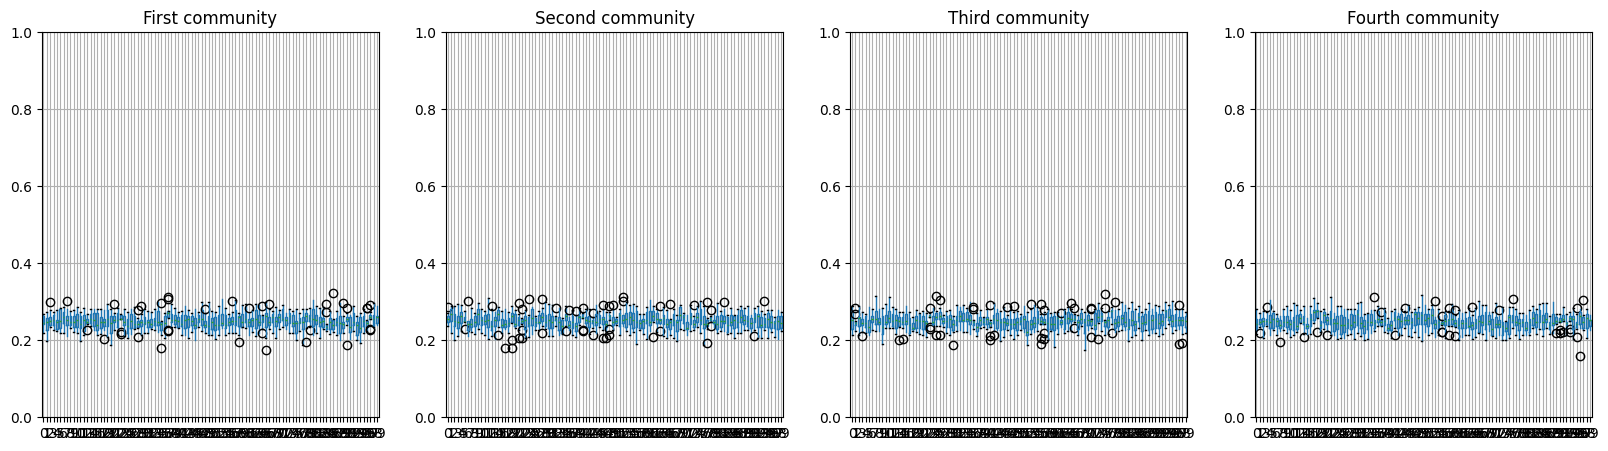

Prior:  [0.7 0.1 0.1 0.1]


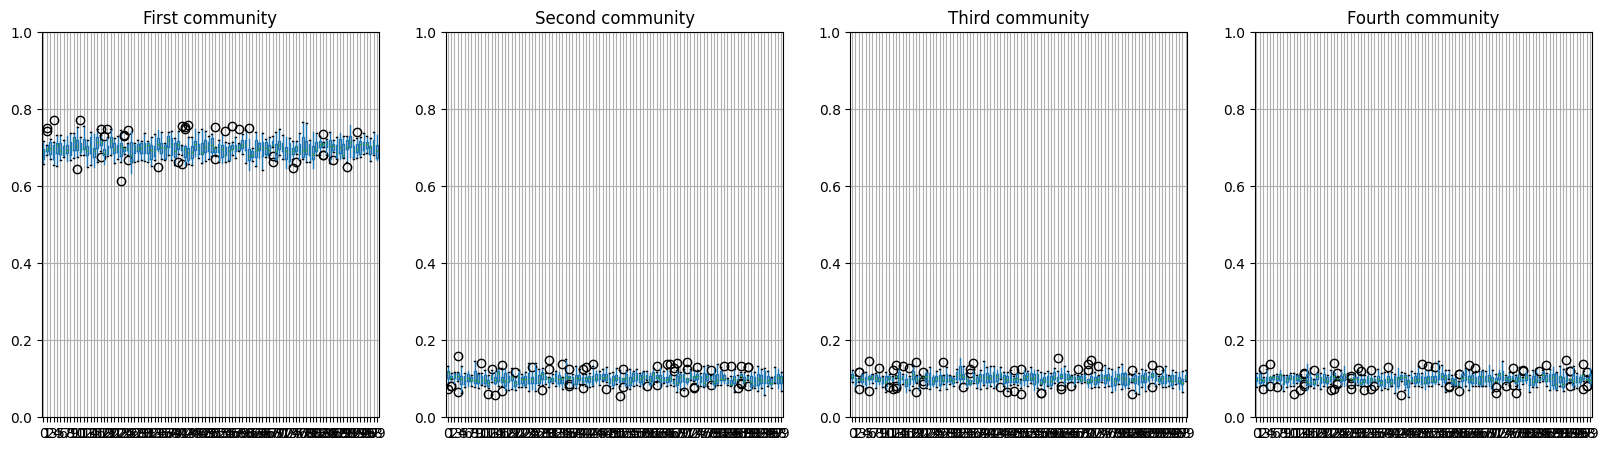

Prior:  [0.4 0.4 0.1 0.1]


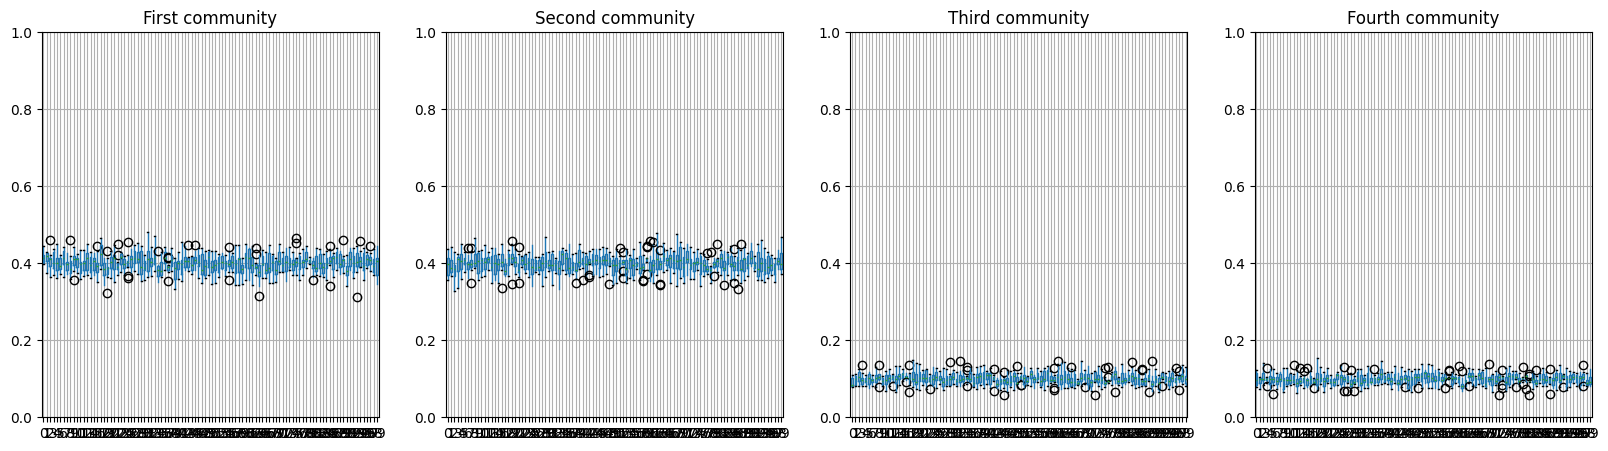

Prior:  [0.3 0.3 0.3 0.1]


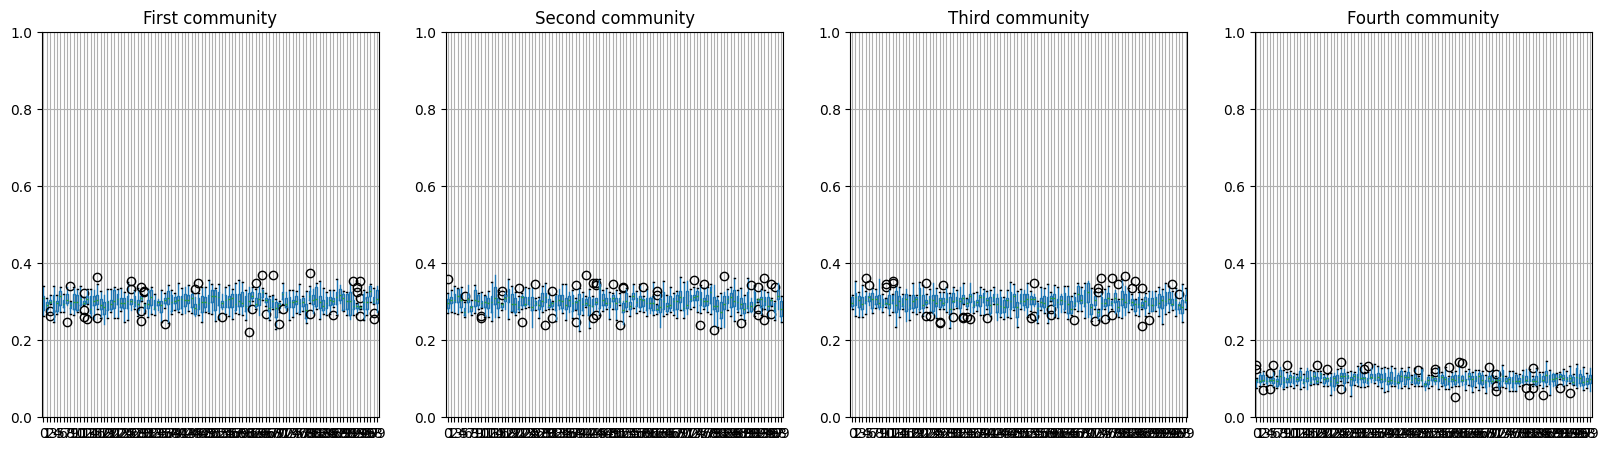

Prior:  [0.4 0.3 0.2 0.1]


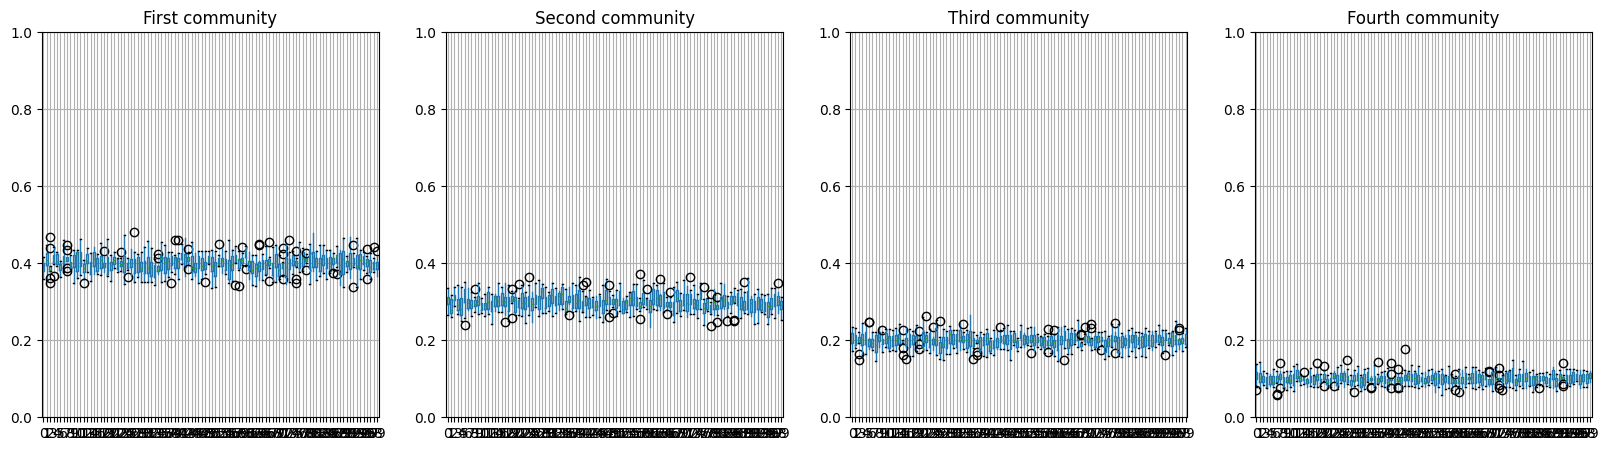

In [15]:
# plot boxplots of community counts (three for each line for commmuinities 1,2,3; while 4 can be inferred)
y_lim = 1
pic = False

for i in range(len(pi_pri_list)):

    df_1 = pd.DataFrame(counts[i, :, :, 0])
    df_2 = pd.DataFrame(counts[i, :, :, 1])
    df_3 = pd.DataFrame(counts[i, :, :, 2])
    df_4 = pd.DataFrame(counts[i, :, :, 3])

    pi_pri = pi_pri_list[i][0, :]
    print("Prior: ", pi_pri)

    plt.figure(figsize=(20, 5))

    plt.subplot(1,4,1)
    plt.title("First community")
    df_1.boxplot()
    plt.ylim(0, y_lim)

    plt.subplot(1,4,2)
    plt.title("Second community")
    df_2.boxplot()
    plt.ylim(0, y_lim)

    plt.subplot(1,4,3)
    plt.title("Third community")
    df_3.boxplot()
    plt.ylim(0, y_lim)

    plt.subplot(1,4,4)
    plt.title("Fourth community")
    df_4.boxplot()
    plt.ylim(0, y_lim)
        
    if pic: plt.savefig(f'adj_Neal_alpha_{alpha}_r_{r}_steps_{steps}.png')

    plt.show()

Possiamo concludere (anche se per completezza bisognerebbe studiarne il comportamento su dati diversi) che c'è un'effettiva convergenza alla prior in questi casi.

# Neal section

## Balanced

We try to understand what happens to class balance picking a symmetric prior on class assignment on Neal's version of the batched Gibbs sampler.
Later on, we test it adding asymmetry to the Dirichlet prior.

In [16]:
gamma = 1 # is the default in the implmentation of Neal's batched Gibbs sampler

In [17]:
r = 20
steps = 300

In [18]:
z_list = np.zeros((r, steps-burn_in + 1, n))

In [19]:
z_0 = warm_initializer(z_true, alpha, n ,k)

# Run the sampler r times steps iterations
for run in range(r):
    print("Current run: ", run)

    batched = Neal_batched_Gibbs_sampler(A, z_0,
                                    alpha_p_pri, beta_p_pri, 
                                    alpha_q_pri, beta_q_pri,
                                    gamma = gamma
                                    )
    batched.run(steps, burn_in = burn_in)
    z_list_batched = batched.get_z_list()
    z_list[run, :, :] = z_list_batched

Current run:  0


100%|██████████| 300/300 [00:02<00:00, 127.44it/s]


Current run:  1


100%|██████████| 300/300 [00:02<00:00, 146.45it/s]


Current run:  2


100%|██████████| 300/300 [00:02<00:00, 145.12it/s]


Current run:  3


100%|██████████| 300/300 [00:02<00:00, 136.88it/s]


Current run:  4


100%|██████████| 300/300 [00:02<00:00, 143.52it/s]


Current run:  5


100%|██████████| 300/300 [00:02<00:00, 144.67it/s]


Current run:  6


100%|██████████| 300/300 [00:02<00:00, 133.97it/s]


Current run:  7


100%|██████████| 300/300 [00:02<00:00, 149.32it/s]


Current run:  8


100%|██████████| 300/300 [00:02<00:00, 146.86it/s]


Current run:  9


100%|██████████| 300/300 [00:02<00:00, 146.63it/s]


Current run:  10


100%|██████████| 300/300 [00:02<00:00, 128.00it/s]


Current run:  11


100%|██████████| 300/300 [00:02<00:00, 137.41it/s]


Current run:  12


100%|██████████| 300/300 [00:02<00:00, 124.66it/s]


Current run:  13


100%|██████████| 300/300 [00:02<00:00, 140.62it/s]


Current run:  14


100%|██████████| 300/300 [00:02<00:00, 134.58it/s]


Current run:  15


100%|██████████| 300/300 [00:02<00:00, 131.05it/s]


Current run:  16


100%|██████████| 300/300 [00:02<00:00, 131.86it/s]


Current run:  17


100%|██████████| 300/300 [00:02<00:00, 138.07it/s]


Current run:  18


100%|██████████| 300/300 [00:02<00:00, 134.38it/s]


Current run:  19


100%|██████████| 300/300 [00:02<00:00, 132.46it/s]


In [20]:
# proportions (counts/n)
counts = np.zeros((r, steps-burn_in + 1, k))
for run in range(r):
    for step in range(steps-burn_in):
        z = z_list[run, step, :]
        for c in range(k):
            counts[run, step, c] = np.sum(z == c)

counts = counts / n

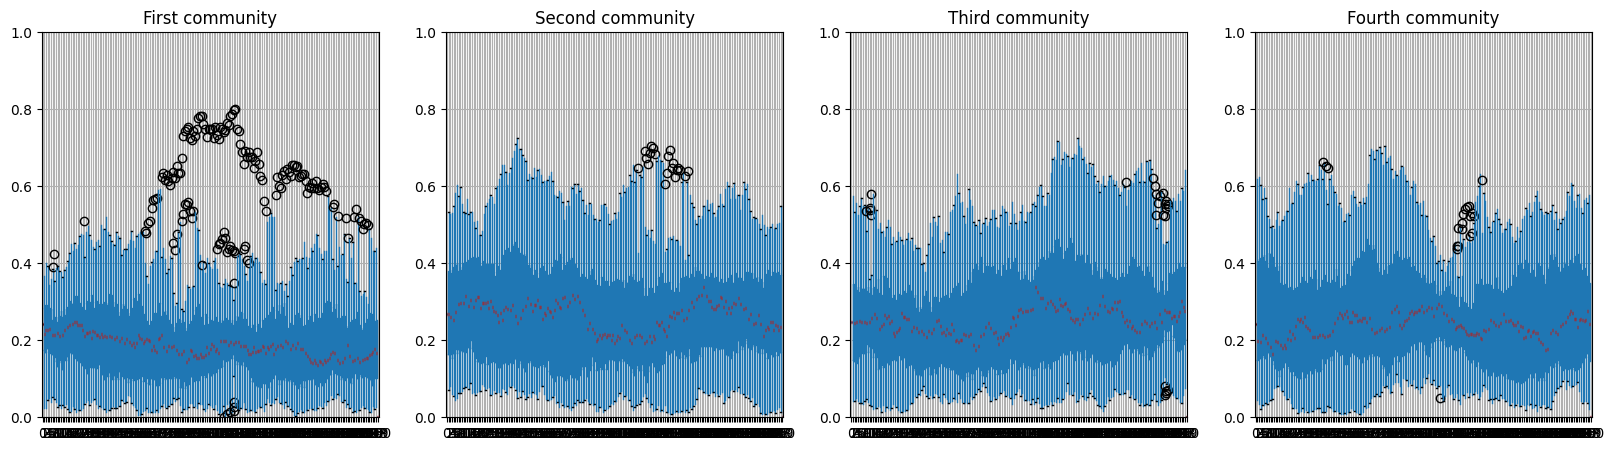

In [27]:
# plot boxplots of community counts (three for each line for commmuinities 1,2,3; while 4 can be inferred)
y_lim = 1
pic = False

df_1 = pd.DataFrame(counts[:, :, 0])
df_2 = pd.DataFrame(counts[:, :, 1])
df_3 = pd.DataFrame(counts[:, :, 2])
df_4 = pd.DataFrame(counts[:, :, 3])

plt.figure(figsize=(20, 5))

medianprops = dict(linestyle='-', linewidth=2.5, color='firebrick')

plt.subplot(1,4,1)
plt.title("First community")
df_1.boxplot(medianprops=medianprops)
plt.ylim(0, y_lim)

plt.subplot(1,4,2)
plt.title("Second community")
df_2.boxplot(medianprops=medianprops)
plt.ylim(0, y_lim)

plt.subplot(1,4,3)
plt.title("Third community")
df_3.boxplot(medianprops=medianprops)
plt.ylim(0, y_lim)

plt.subplot(1,4,4)
plt.title("Fourth community")
df_4.boxplot(medianprops=medianprops)
plt.ylim(0, y_lim)
    
if pic: plt.savefig(f'adj_Neal_alpha_{alpha}_r_{r}_steps_{steps}.png')

plt.show()

## Same simulation with different data

In [ ]:
# run the samplers r times for each prior, for steps iterations

r = 10 # number of iterations for each value of alpha in the mesh
steps = 200 #iterations of the batched sampler
alpha = 0.4
burn_in = 100
n_data = 5
# pi_pri_list
z_list_list = np.zeros((n_data, r, steps-burn_in, n))
gamma = 1

np.random.seed(0)

for i in range(n_data):
    print("Current network: ", i+1)
    A, z_true = generate_homogeneous_sbm(n, k, p, q, z_t=z_ex)
    z_0 = warm_initializer(z_true, alpha, n ,k)

    # Run the sampler r times steps iterations
    for run in range(r):
        print("Current run: ", run)

        batched = Neal_batched_Gibbs_sampler(A, z_0,
                                        alpha_p_pri, beta_p_pri, 
                                        alpha_q_pri, beta_q_pri, 
                                        gamma = gamma
                                        )
        batched.run(steps, burn_in = burn_in)
        z_list_batched = batched.get_z_list()[1:] #remove the starting point
        z_list_list[i, run, :, :] = z_list_batched
# counts?
counts = np.zeros((len(pi_pri_list), r, steps-burn_in, k))
for i in range(n_data):
    for run in range(r):
        for step in range(steps-burn_in):
            z = z_list_list[i, run, step, :]
            for c in range(k):
                counts[i, run, step, c] = np.sum(z == c)

counts = counts / n

Simulated network number:  1


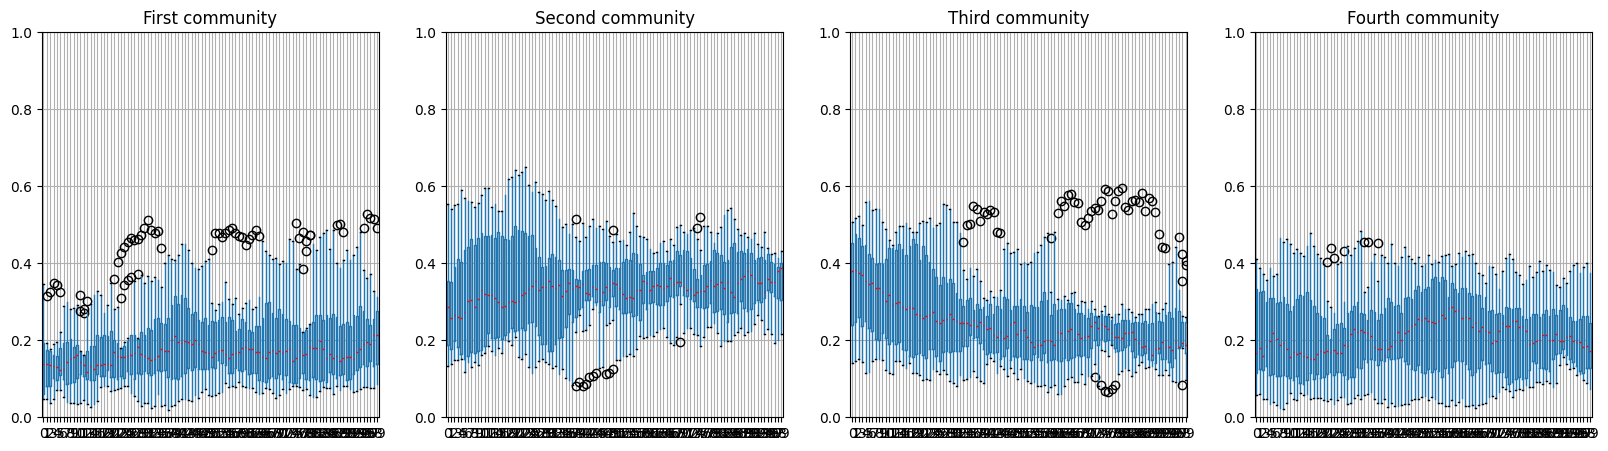

Simulated network number:  2


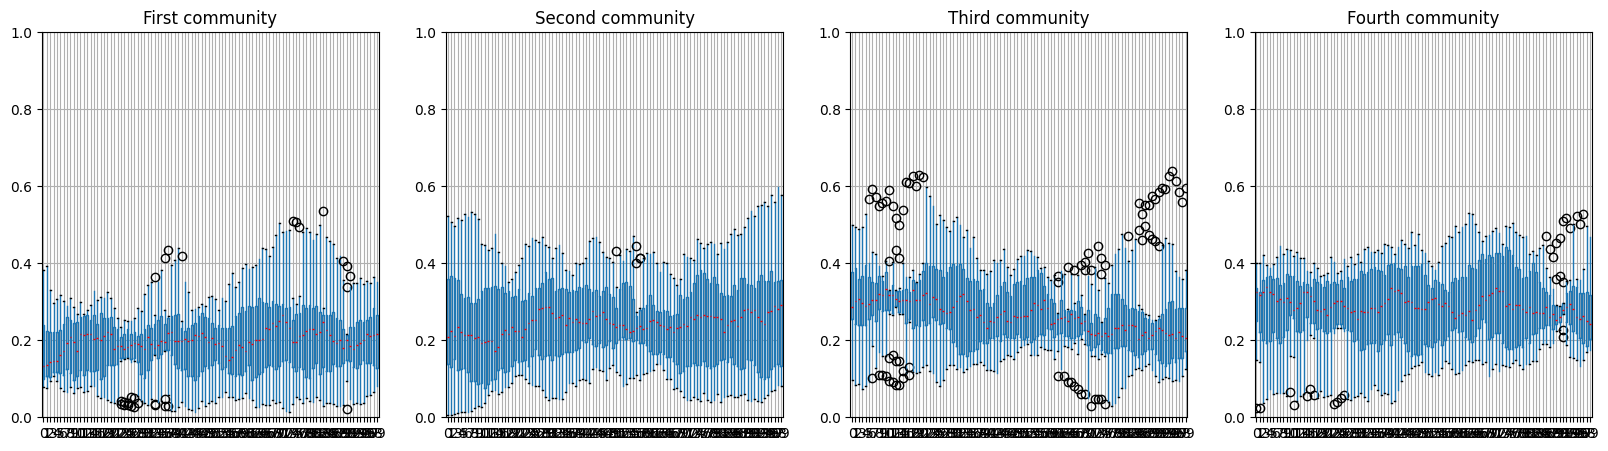

Simulated network number:  3


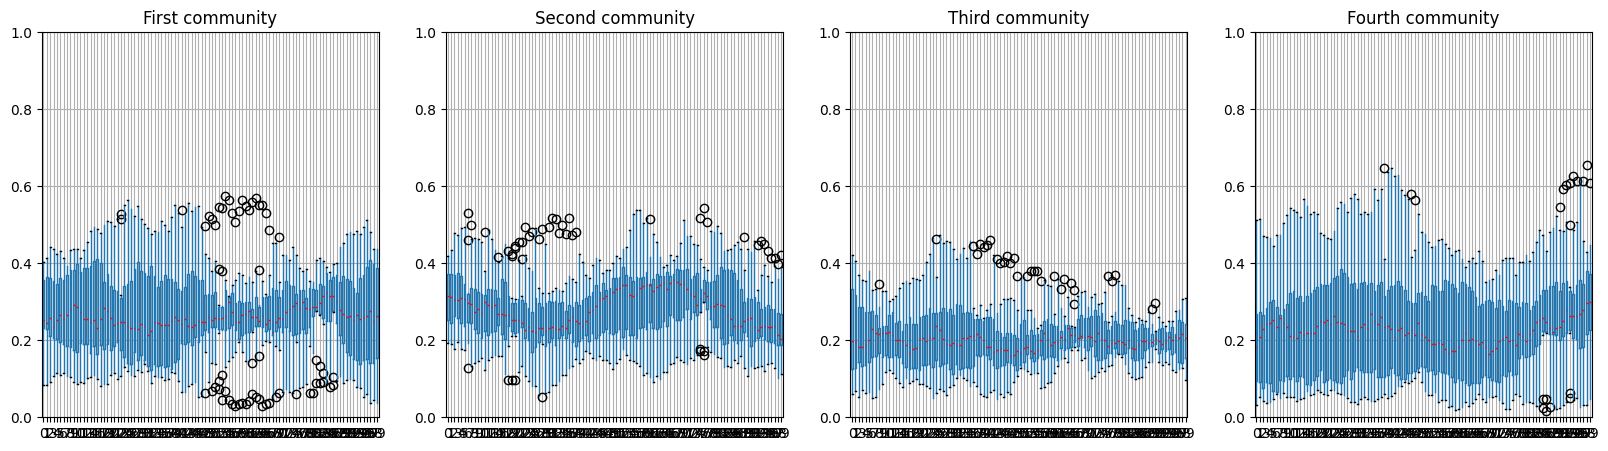

Simulated network number:  4


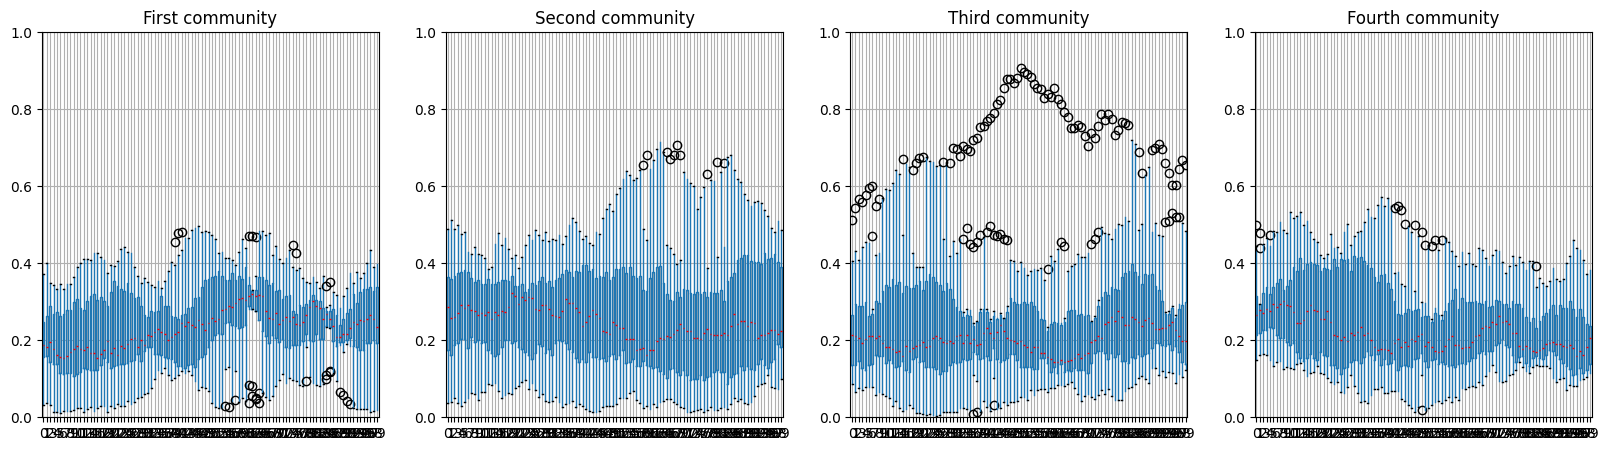

Simulated network number:  5


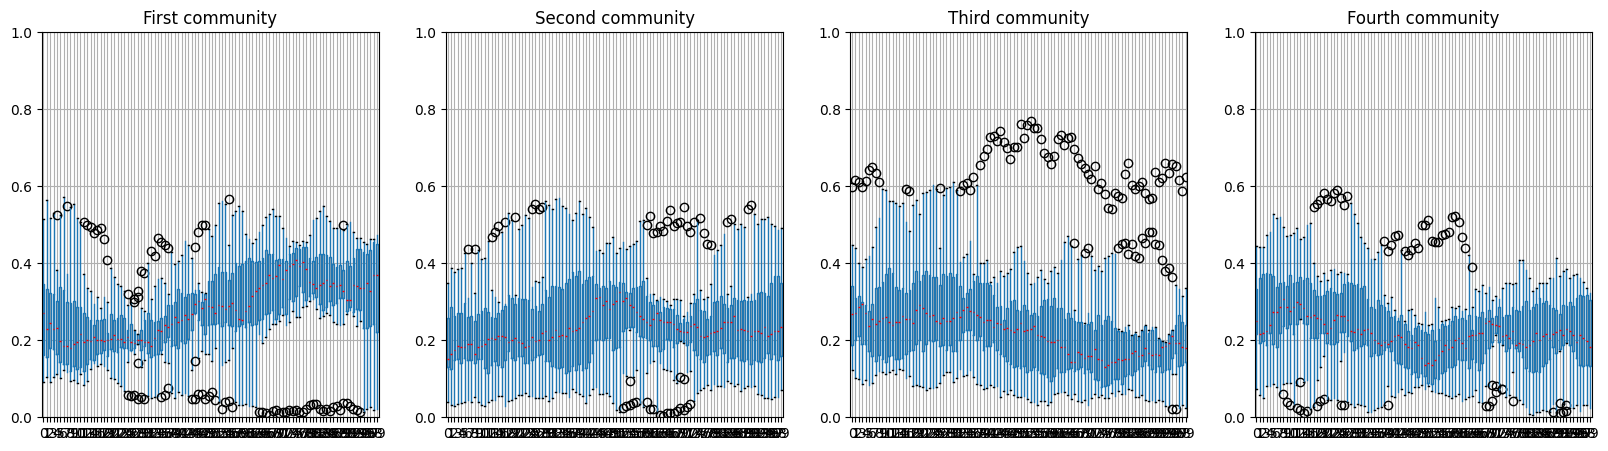

In [31]:

# plot boxplots of community counts (three for each line for commmuinities 1,2,3; while 4 can be inferred)
y_lim = 1
pic = False

for i in range(n_data):

    df_1 = pd.DataFrame(counts[i, :, :, 0])
    df_2 = pd.DataFrame(counts[i, :, :, 1])
    df_3 = pd.DataFrame(counts[i, :, :, 2])
    df_4 = pd.DataFrame(counts[i, :, :, 3])

    print("Simulated network number: ", i+1)

    medianprops = {'color': 'red'}

    plt.figure(figsize=(20, 5))

    plt.subplot(1,4,1)
    plt.title("First community")
    df_1.boxplot(medianprops=medianprops)
    plt.ylim(0, y_lim)

    plt.subplot(1,4,2)
    plt.title("Second community")
    df_2.boxplot(medianprops=medianprops)
    plt.ylim(0, y_lim)

    plt.subplot(1,4,3)
    plt.title("Third community")
    df_3.boxplot(medianprops=medianprops)
    plt.ylim(0, y_lim)

    plt.subplot(1,4,4)
    plt.title("Fourth community")
    df_4.boxplot(medianprops=medianprops)
    plt.ylim(0, y_lim)
        
    if pic: plt.savefig(f'adj_Neal_alpha_{alpha}_r_{r}_steps_{steps}.png')

    plt.show()

## Check with asymmetric prior

In [25]:
gamma = [1, 1, 1, 1]
r = 5
steps = 1000
z_list = np.zeros((r, steps-burn_in + 1, n))
alpha = 0.4
z_0 = warm_initializer(z_true, alpha, n ,k)

# Run the sampler r times steps iterations
for run in range(r):
    print("Current run: ", run)

    batched = Neal_batched_Gibbs_sampler(A, z_0,
                                    alpha_p_pri, beta_p_pri, 
                                    alpha_q_pri, beta_q_pri,
                                    gamma = gamma
                                    )
    batched.run(steps, burn_in = burn_in)
    z_list_batched = batched.get_z_list()
    z_list[run, :, :] = z_list_batched
# proportions (counts/n)
counts = np.zeros((r, steps-burn_in + 1, k))
for run in range(r):
    for step in range(steps-burn_in):
        z = z_list[run, step, :]
        for c in range(k):
            counts[run, step, c] = np.sum(z == c)

counts = counts / n


Current run:  0


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:07<00:00, 125.44it/s]


Current run:  1


100%|██████████| 1000/1000 [00:07<00:00, 136.97it/s]


Current run:  2


100%|██████████| 1000/1000 [00:07<00:00, 142.37it/s]


Current run:  3


100%|██████████| 1000/1000 [00:07<00:00, 137.83it/s]


Current run:  4


100%|██████████| 1000/1000 [00:07<00:00, 127.86it/s]


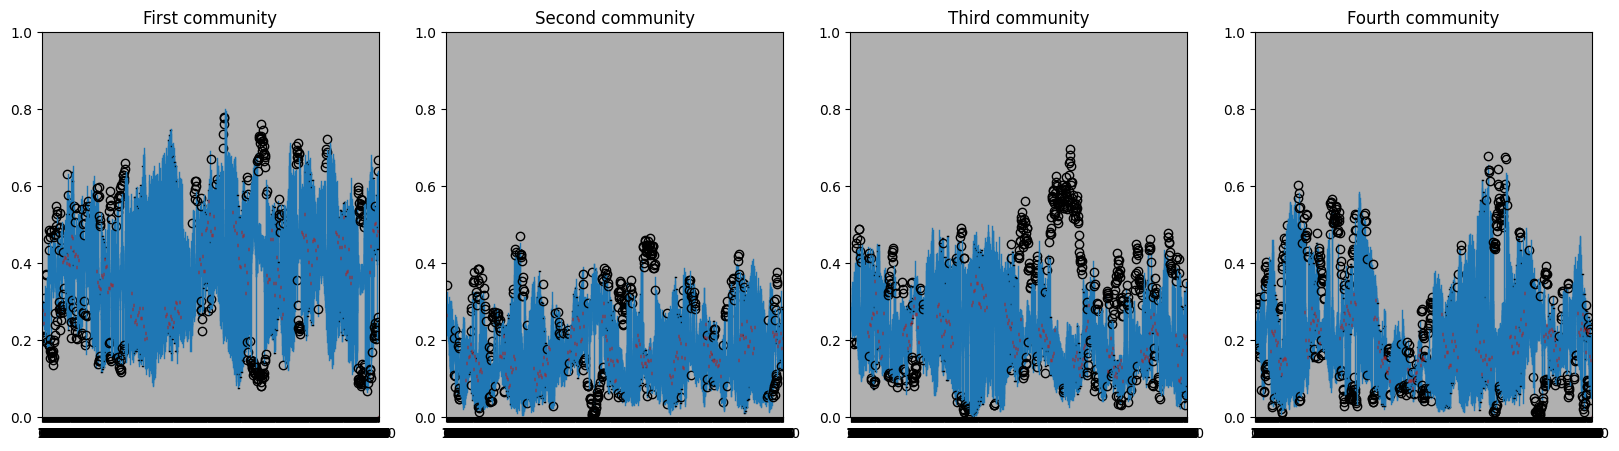

In [26]:
# plot boxplots of community counts (three for each line for commmuinities 1,2,3; while 4 can be inferred)
y_lim = 1
pic = False

df_1 = pd.DataFrame(counts[:, :, 0])
df_2 = pd.DataFrame(counts[:, :, 1])
df_3 = pd.DataFrame(counts[:, :, 2])
df_4 = pd.DataFrame(counts[:, :, 3])

plt.figure(figsize=(20, 5))

medianprops = dict(linestyle='-', linewidth=2.5, color='firebrick')

plt.subplot(1,4,1)
plt.title("First community")
df_1.boxplot(medianprops=medianprops)
plt.ylim(0, y_lim)

plt.subplot(1,4,2)
plt.title("Second community")
df_2.boxplot(medianprops=medianprops)
plt.ylim(0, y_lim)

plt.subplot(1,4,3)
plt.title("Third community")
df_3.boxplot(medianprops=medianprops)
plt.ylim(0, y_lim)

plt.subplot(1,4,4)
plt.title("Fourth community")
df_4.boxplot(medianprops=medianprops)
plt.ylim(0, y_lim)
    
if pic: plt.savefig(f'adj_Neal_alpha_{alpha}_r_{r}_steps_{steps}.png')

plt.show()

It's not perfectly clear what happens, **problem with understanding the underlying distribution of the prior**, but on the long run the community assignments are clearly affected by the choice of the prior parameters.

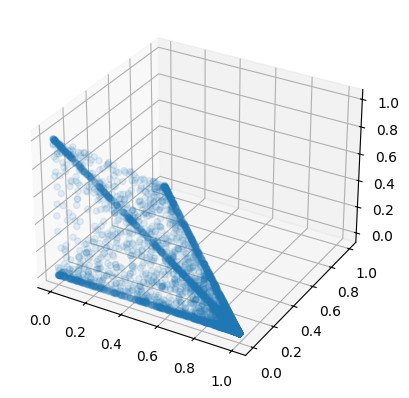

In [38]:
# %matplotlib inline

# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
# from scipy.stats import dirichlet

# # Define the parameters of the Dirichlet distribution
# alpha = [0.7, 0.1, 0.1, 0.1]

# # Generate samples from the Dirichlet distribution
# samples = dirichlet(alpha).rvs(5000)

# # Convert the 4D Dirichlet distribution to a 3D distribution
# # This is done by discarding one dimension
# samples_3d = samples[:, :3]

# # Create a 3D scatter plot of the samples
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(samples_3d[:, 0], samples_3d[:, 1], samples_3d[:, 2], alpha = 0.1)

# plt.show()